<a href="https://colab.research.google.com/github/ASHIKAMOHAN/GalaxyProject/blob/main/GalaxyDistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [2]:

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Function to load datasets
def load_data():
    happy_files = [
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_A.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_D.txt'
    ]
    teddy_files = [
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_A.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_D.txt'
    ]

    happy_dfs = [pd.read_csv(file, delimiter='\t') for file in happy_files]
    teddy_dfs = [pd.read_csv(file, delimiter='\t', skiprows=6) for file in teddy_files]

    return happy_dfs, teddy_dfs




In [4]:
# Load datasets
happy_dfs, teddy_dfs = load_data()

# Define the correct column names
column_names = ['id', 'mag_r', 'u-g', 'g-r', 'r-i', 'i-z', 'z_spec', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5']

In [5]:
# Clean and rename columns
def clean_and_rename_columns(dfs, column_names):
    cleaned_dfs = []
    for df in dfs:
        if df.shape[1] == 1:
            df = df.iloc[:, 0].str.split(expand=True)
        df.columns = column_names
        cleaned_dfs.append(df)
    return cleaned_dfs

# Apply the function to all datasets
happy_dfs = clean_and_rename_columns(happy_dfs, column_names)
teddy_dfs = clean_and_rename_columns(teddy_dfs, column_names)



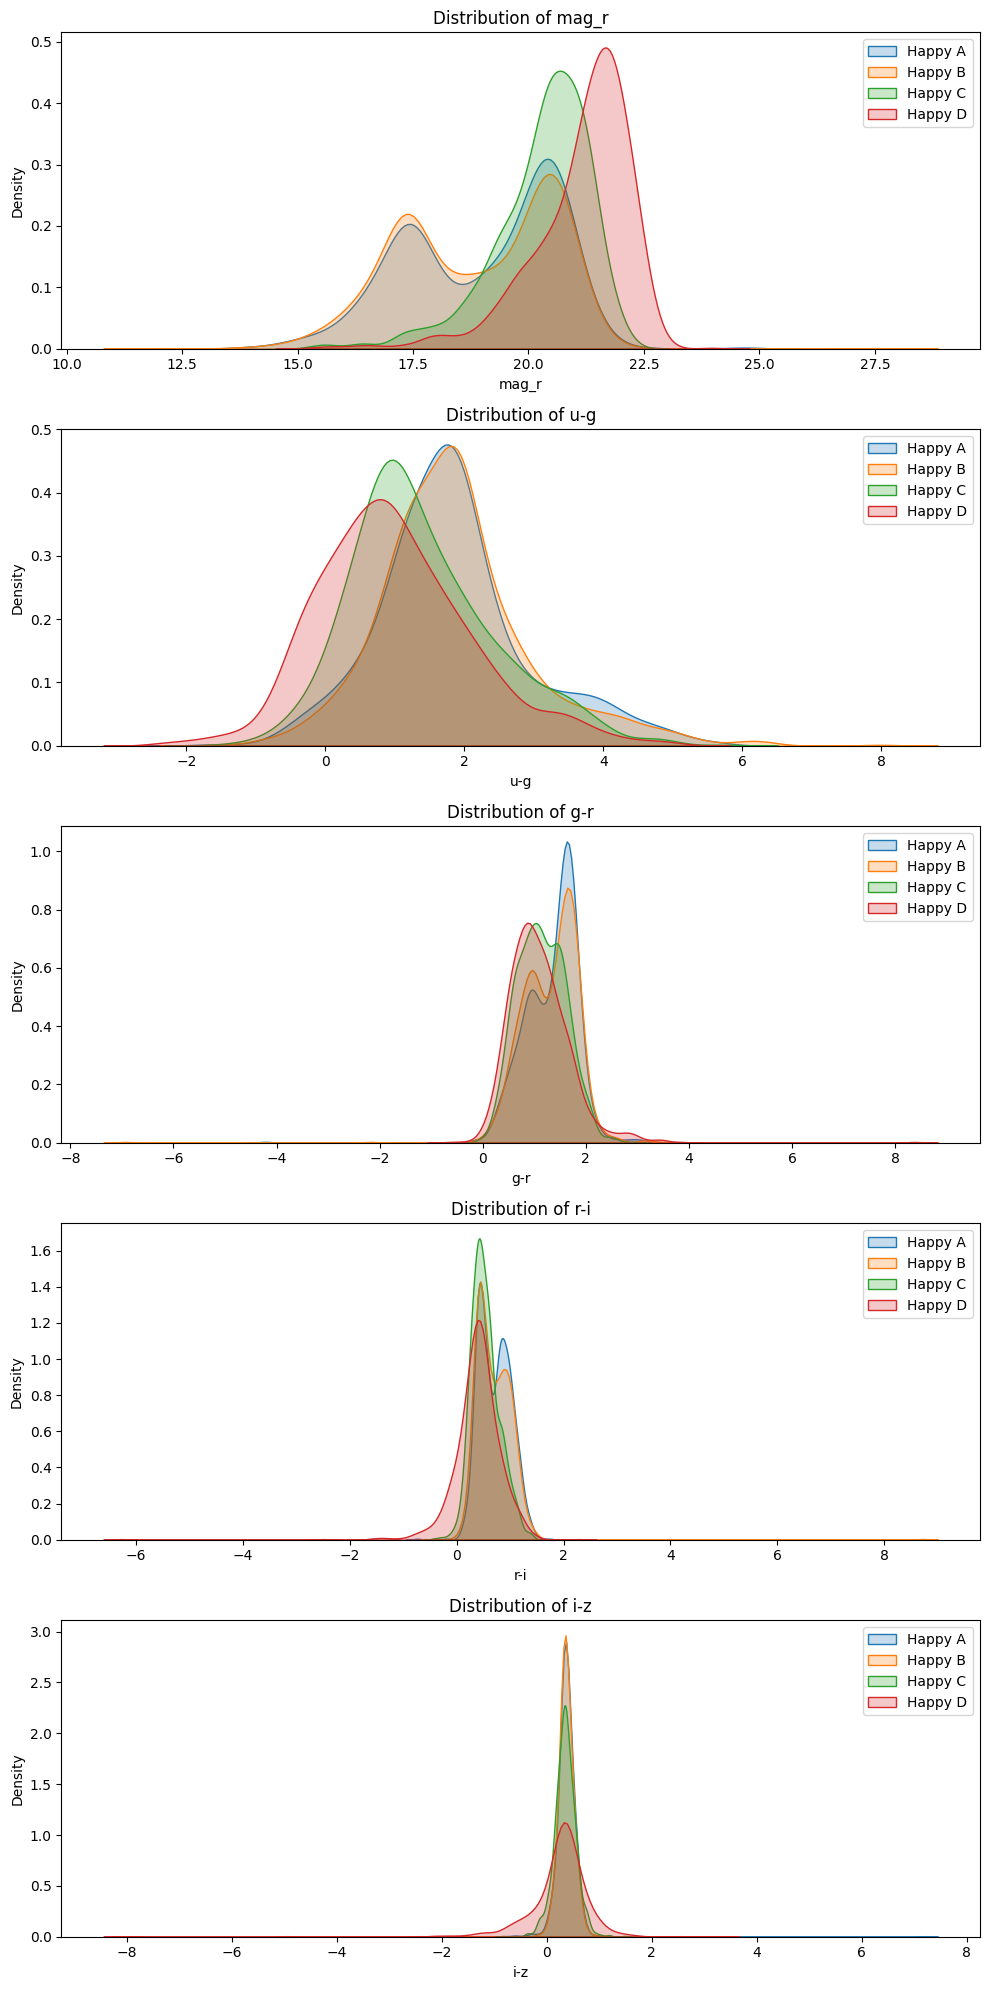

In [6]:
# Convert columns to numeric
def convert_to_numeric(dfs):
    for df in dfs:
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return dfs

# Convert the dataframes to numeric
happy_dfs = convert_to_numeric(happy_dfs)
teddy_dfs = convert_to_numeric(teddy_dfs)

# Function to sample data for faster plotting
def sample_data(dfs, sample_size=1000):
    sampled_dfs = [df.sample(n=min(sample_size, len(df)), random_state=42) for df in dfs]
    return sampled_dfs

# Sample the data
happy_dfs_sampled = sample_data(happy_dfs)
teddy_dfs_sampled = sample_data(teddy_dfs)

# Function to plot histograms and KDE
def plot_histograms_and_kde(dfs, labels, columns):
    fig, axes = plt.subplots(len(columns), 1, figsize=(10, 20))
    for col, ax in zip(columns, axes):
        for df, label in zip(dfs, labels):
            sns.kdeplot(df[col], fill=True, label=label, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Plot distributions for Happy datasets
columns_to_plot = ['mag_r', 'u-g', 'g-r', 'r-i', 'i-z']
happy_labels = ['Happy A', 'Happy B', 'Happy C', 'Happy D']

plot_histograms_and_kde(happy_dfs_sampled, happy_labels, columns_to_plot)

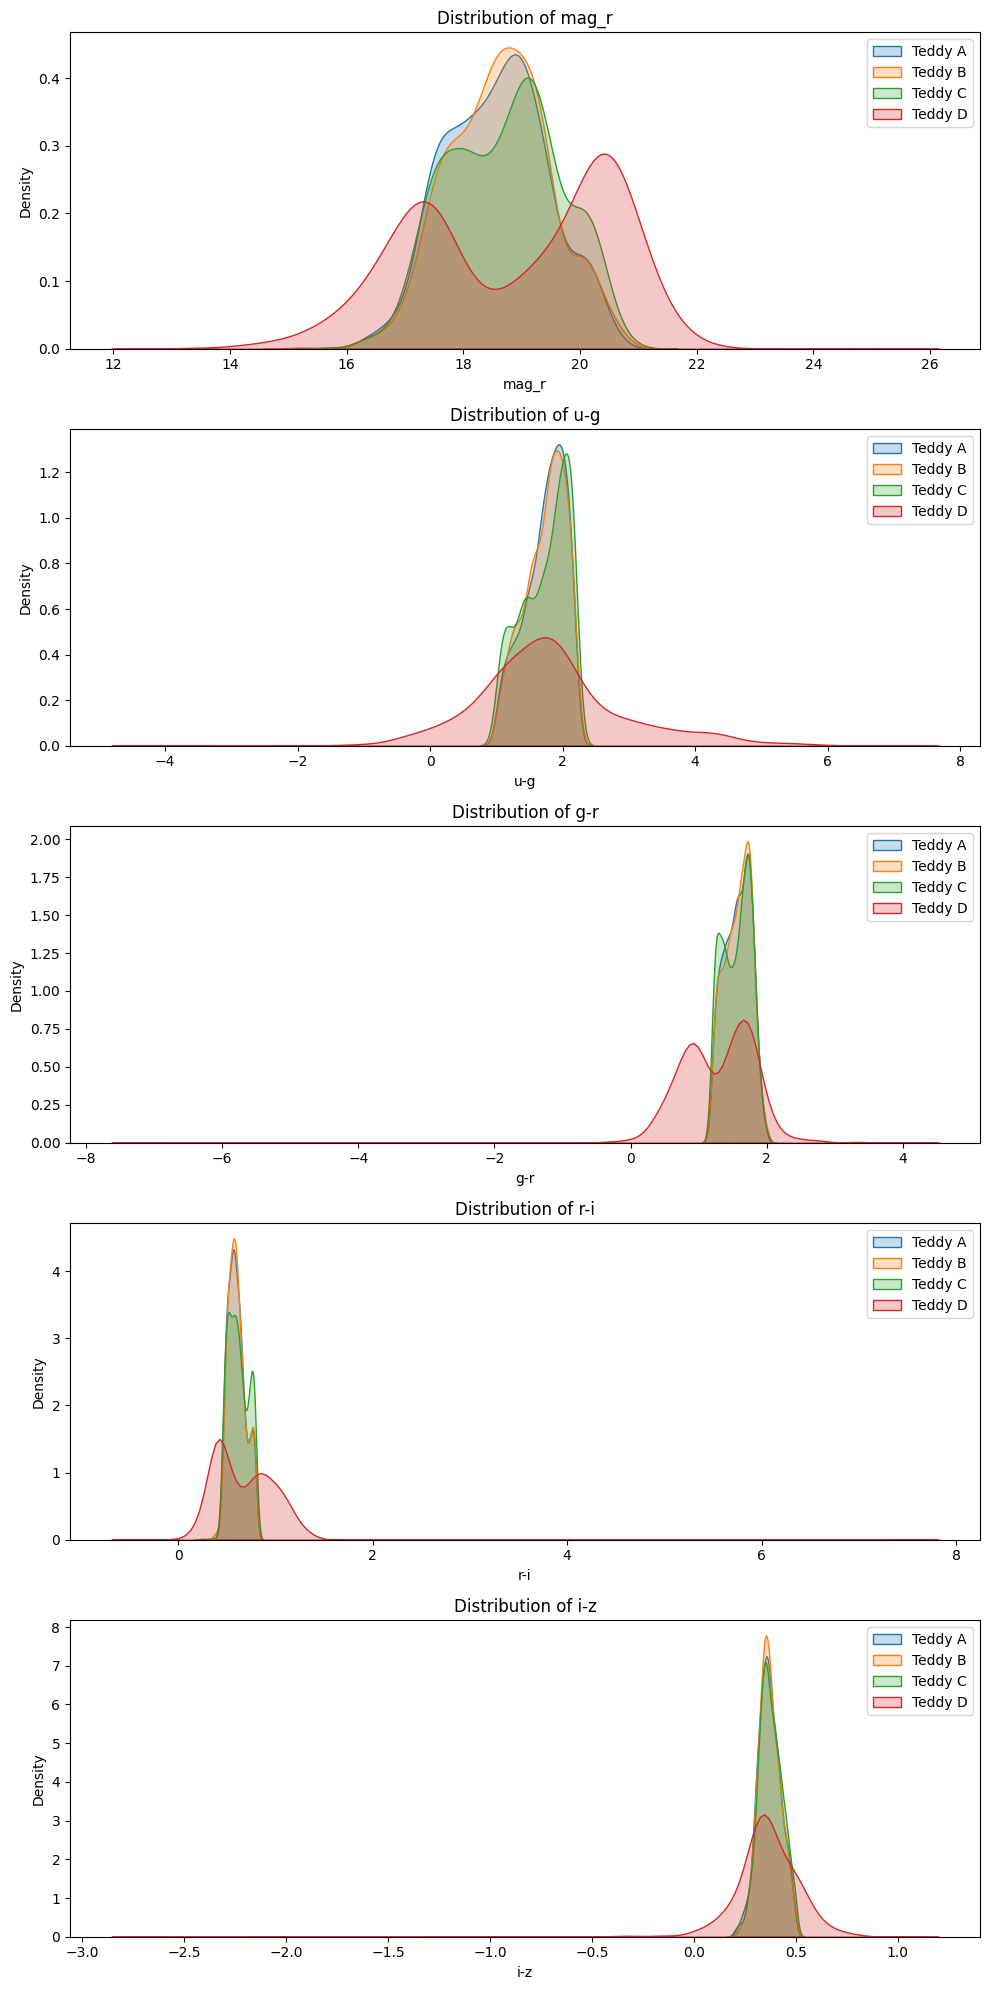

In [7]:
# Plot distributions for Teddy datasets
teddy_labels = ['Teddy A', 'Teddy B', 'Teddy C', 'Teddy D']

plot_histograms_and_kde(teddy_dfs_sampled, teddy_labels, columns_to_plot)

In [8]:
# Preprocess data
def preprocess_data(df):
    X = df.drop('z_spec', axis=1).astype(float)
    y = df['z_spec'].astype(float)
    return X, y

# Preprocess the datasets
def preprocess_datasets(dfs):
    X_train, y_train = preprocess_data(dfs[0])
    X_val, y_val = preprocess_data(dfs[1])
    X_test_b, y_test_b = preprocess_data(dfs[1])
    X_test_c, y_test_c = preprocess_data(dfs[2])
    X_test_d, y_test_d = preprocess_data(dfs[3])
    return X_train, y_train, X_val, y_val, X_test_b, y_test_b, X_test_c, y_test_c, X_test_d, y_test_d

# Happy datasets
X_train_happy, y_train_happy, X_val_happy, y_val_happy, X_test_happy_b,y_test_happy_b, X_test_happy_c, y_test_happy_c, X_test_happy_d, y_test_happy_d = preprocess_datasets(happy_dfs)

# Teddy datasets
X_train_teddy, y_train_teddy, X_val_teddy, y_val_teddy, X_test_teddy_b,y_test_teddy_b, X_test_teddy_c, y_test_teddy_c, X_test_teddy_d, y_test_teddy_d = preprocess_datasets(teddy_dfs)

def handle_nan(df):
    if df.isnull().values.any():
        df = df.fillna(df.mean())
    return df

# Apply NaN handling to datasets
X_train_happy = handle_nan(X_train_happy)
X_val_happy = handle_nan(X_val_happy)
X_test_happy_b = handle_nan(X_test_happy_b)
X_test_happy_c = handle_nan(X_test_happy_c)
X_test_happy_d = handle_nan(X_test_happy_d)
y_train_happy = handle_nan(y_train_happy)
y_val_happy = handle_nan(y_val_happy)
y_test_happy_b = handle_nan(y_test_happy_b)
y_test_happy_c = handle_nan(y_test_happy_c)
y_test_happy_d = handle_nan(y_test_happy_d)

X_train_teddy = handle_nan(X_train_teddy)
X_val_teddy = handle_nan(X_val_teddy)
X_test_teddy_b = handle_nan(X_test_teddy_b)
X_test_teddy_c = handle_nan(X_test_teddy_c)
X_test_teddy_d = handle_nan(X_test_teddy_d)
y_train_teddy = handle_nan(y_train_teddy)
y_val_teddy = handle_nan(y_val_teddy)
y_test_teddy_b = handle_nan(y_test_teddy_b)
y_test_teddy_c = handle_nan(y_test_teddy_c)
y_test_teddy_d = handle_nan(y_test_teddy_d)

# Verify no NaN values are present
def verify_no_nan(df, name):
    if df.isnull().values.any():
        print(f"NaN values found in {name}")
    else:
        print(f"No NaN values in {name}")

# Verify all datasets
verify_no_nan(X_train_happy, 'X_train_happy')
verify_no_nan(X_val_happy, 'X_val_happy')
verify_no_nan(X_test_happy_b, 'X_test_happy_b')
verify_no_nan(X_test_happy_c, 'X_test_happy_c')
verify_no_nan(X_test_happy_d, 'X_test_happy_d')
verify_no_nan(y_train_happy, 'y_train_happy')
verify_no_nan(y_val_happy, 'y_val_happy')
verify_no_nan(y_test_happy_b, 'y_test_happy_b')
verify_no_nan(y_test_happy_c, 'y_test_happy_c')
verify_no_nan(y_test_happy_d, 'y_test_happy_d')

verify_no_nan(X_train_teddy, 'X_train_teddy')
verify_no_nan(X_val_teddy, 'X_val_teddy')
verify_no_nan(X_test_teddy_b, 'X_test_teddy_b')
verify_no_nan(X_test_teddy_c, 'X_test_teddy_c')
verify_no_nan(X_test_teddy_d, 'X_test_teddy_d')
verify_no_nan(y_train_teddy, 'y_train_teddy')
verify_no_nan(y_val_teddy, 'y_val_teddy')
verify_no_nan(y_test_teddy_b, 'y_test_teddy_b')
verify_no_nan(y_test_teddy_c, 'y_test_teddy_c')
verify_no_nan(y_test_teddy_d, 'y_test_teddy_d')

No NaN values in X_train_happy
No NaN values in X_val_happy
No NaN values in X_test_happy_b
No NaN values in X_test_happy_c
No NaN values in X_test_happy_d
No NaN values in y_train_happy
No NaN values in y_val_happy
No NaN values in y_test_happy_b
No NaN values in y_test_happy_c
No NaN values in y_test_happy_d
No NaN values in X_train_teddy
No NaN values in X_val_teddy
No NaN values in X_test_teddy_b
No NaN values in X_test_teddy_c
No NaN values in X_test_teddy_d
No NaN values in y_train_teddy
No NaN values in y_val_teddy
No NaN values in y_test_teddy_b
No NaN values in y_test_teddy_c
No NaN values in y_test_teddy_d


In [9]:
# Load weights
def load_weights():
    weight_files = [
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_D.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_D.txt'
    ]
    weights = [pd.read_csv(file, delimiter='\t', header=None).values.flatten() for file in weight_files]
    return weights

weights = load_weights()



In [10]:
# Adjust weights lengths to match validation and test sets
def adjust_weights(weights, X_val_happy, X_test_happy_b, X_test_happy_c, X_test_happy_d,
                   X_val_teddy, X_test_teddy_b, X_test_teddy_c, X_test_teddy_d):
    len_val_happy = len(X_val_happy)
    len_test_happy_b = len(X_test_happy_b)
    len_test_happy_c = len(X_test_happy_c)
    len_test_happy_d = len(X_test_happy_d)
    len_val_teddy = len(X_val_teddy)
    len_test_teddy_b = len(X_test_teddy_b)
    len_test_teddy_c = len(X_test_teddy_c)
    len_test_teddy_d = len(X_test_teddy_d)

    weights_val_happy = weights[0][:len_val_happy]
    weights_test_happy_b = weights[0][:len_test_happy_b]
    weights_test_happy_c = weights[1][:len_test_happy_c]
    weights_test_happy_d = weights[2][:len_test_happy_d]
    weights_val_teddy = weights[3][:len_val_teddy]
    weights_test_teddy_b = weights[3][:len_test_teddy_b]
    weights_test_teddy_c = weights[4][:len_test_teddy_c]
    weights_test_teddy_d = weights[5][:len_test_teddy_d]

    # Adjust weights to match lengths
    if len(weights_val_happy) < len_val_happy:
        weights_val_happy = np.concatenate([weights_val_happy, np.ones(len_val_happy - len(weights_val_happy))])
    if len(weights_test_happy_b) < len_test_happy_b:
        weights_test_happy_b = np.concatenate([weights_test_happy_b, np.ones(len_test_happy_b - len(weights_test_happy_b))])
    if len(weights_test_happy_c) < len_test_happy_c:
        weights_test_happy_c = np.concatenate([weights_test_happy_c, np.ones(len_test_happy_c - len(weights_test_happy_c))])
    if len(weights_test_happy_d) < len_test_happy_d:
        weights_test_happy_d = np.concatenate([weights_test_happy_d, np.ones(len_test_happy_d - len(weights_test_happy_d))])

    if len(weights_val_teddy) < len_val_teddy:
        weights_val_teddy = np.concatenate([weights_val_teddy, np.ones(len_val_teddy - len(weights_val_teddy))])
    if len(weights_test_teddy_b) < len_test_teddy_b:
        weights_test_teddy_b = np.concatenate([weights_test_teddy_b, np.ones(len_test_teddy_b - len(weights_test_teddy_b))])
    if len(weights_test_teddy_c) < len_test_teddy_c:
        weights_test_teddy_c = np.concatenate([weights_test_teddy_c, np.ones(len_test_teddy_c - len(weights_test_teddy_c))])
    if len(weights_test_teddy_d) < len_test_teddy_d:
        weights_test_teddy_d = np.concatenate([weights_test_teddy_d, np.ones(len_test_teddy_d - len(weights_test_teddy_d))])

    return weights_val_happy, weights_test_happy_b, weights_test_happy_c, weights_test_happy_d, weights_val_teddy, weights_test_teddy_b, weights_test_teddy_c, weights_test_teddy_d

# Adjust weights lengths to match validation and test sets
weights_val_happy, weights_test_happy_b, weights_test_happy_c, weights_test_happy_d, weights_val_teddy, weights_test_teddy_b, weights_test_teddy_c, weights_test_teddy_d = adjust_weights(weights, X_val_happy, X_test_happy_b, X_test_happy_c, X_test_happy_d, X_val_teddy, X_test_teddy_b, X_test_teddy_c, X_test_teddy_d)

print('Length of X_train_happy:', len(X_train_happy))
print('Length of y_train_happy:', len(y_train_happy))
print('Length of X_val_happy:', len(X_val_happy))
print('Length of y_val_happy:', len(y_val_happy))
print('Length of weights_val_happy:', len(weights_val_happy))
print('Length of X_test_happy_b:', len(X_test_happy_b))
print('Length of y_test_happy_b:', len(y_test_happy_b))
print('Length of weights_test_happy_b:', len(weights_test_happy_b))
print('Length of X_test_happy_c:', len(X_test_happy_c))
print('Length of y_test_happy_c:', len(y_test_happy_c))
print('Length of weights_test_happy_c:', len(weights_test_happy_c))
print('Length of X_test_happy_d:', len(X_test_happy_d))
print('Length of y_test_happy_d:', len(y_test_happy_d))
print('Length of weights_test_happy_d:', len(weights_test_happy_d))

print('Length of X_train_teddy:', len(X_train_teddy))
print('Length of y_train_teddy:', len(y_train_teddy))
print('Length of X_val_teddy:', len(X_val_teddy))
print('Length of y_val_teddy:', len(y_val_teddy))
print('Length of weights_val_teddy:', len(weights_val_teddy))
print('Length of X_test_teddy_b:', len(X_test_teddy_b))
print('Length of y_test_teddy_b:', len(y_test_teddy_b))
print('Length of weights_test_teddy_b:', len(weights_test_teddy_b))
print('Length of X_test_teddy_c:', len(X_test_teddy_c))
print('Length of y_test_teddy_c:', len(y_test_teddy_c))
print('Length of weights_test_teddy_c:', len(weights_test_teddy_c))
print('Length of X_test_teddy_d:', len(X_test_teddy_d))
print('Length of y_test_teddy_d:', len(y_test_teddy_d))
print('Length of weights_test_teddy_d:', len(weights_test_teddy_d))

Length of X_train_happy: 74950
Length of y_train_happy: 74950
Length of X_val_happy: 74900
Length of y_val_happy: 74900
Length of weights_val_happy: 74900
Length of X_test_happy_b: 74900
Length of y_test_happy_b: 74900
Length of weights_test_happy_b: 74900
Length of X_test_happy_c: 60315
Length of y_test_happy_c: 60315
Length of weights_test_happy_c: 60315
Length of X_test_happy_d: 74642
Length of y_test_happy_d: 74642
Length of weights_test_happy_d: 74642
Length of X_train_teddy: 74309
Length of y_train_teddy: 74309
Length of X_val_teddy: 74557
Length of y_val_teddy: 74557
Length of weights_val_teddy: 74557
Length of X_test_teddy_b: 74557
Length of y_test_teddy_b: 74557
Length of weights_test_teddy_b: 74557
Length of X_test_teddy_c: 97980
Length of y_test_teddy_c: 97980
Length of weights_test_teddy_c: 97980
Length of X_test_teddy_d: 75924
Length of y_test_teddy_d: 75924
Length of weights_test_teddy_d: 75924


In [11]:
# Model training functions

# Random Forest
def train_random_forest(X_train, y_train, X_val, y_val, weights_train, weights_val):
  rf = RandomForestRegressor()
  rf.fit(X_train, y_train, sample_weight=weights_train)
  y_pred_rf = rf.predict(X_val)
  rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False, sample_weight=weights_val)
  r2_rf = r2_score(y_val, y_pred_rf)
  mae_rf = mean_absolute_error(y_val, y_pred_rf)
  medae_rf = median_absolute_error(y_val, y_pred_rf)
  return y_pred_rf, rmse_rf, r2_rf, mae_rf, medae_rf

In [12]:
def train_gradient_boost(X_train, y_train, X_val, y_val, weights_train, weights_val):
  gb = GradientBoostingRegressor()
  gb.fit(X_train, y_train, sample_weight=weights_train)
  y_pred_gb = gb.predict(X_val)
  rmse_gb = mean_squared_error(y_val, y_pred_gb, squared=False, sample_weight=weights_val)
  r2_gb = r2_score(y_val, y_pred_gb)
  mae_gb = mean_absolute_error(y_val, y_pred_gb)
  medae_gb = median_absolute_error(y_val, y_pred_gb)
  return y_pred_gb, rmse_gb, r2_gb, mae_gb, medae_gb

In [13]:
def train_decision_tree(X_train, y_train, X_val, y_val, weights_train=None, weights_val=None):
  dt = DecisionTreeRegressor()
  dt.fit(X_train, y_train)
  y_pred_dt = dt.predict(X_val)
  rmse_dt = mean_squared_error(y_val, y_pred_dt, squared=False)
  r2_dt = r2_score(y_val, y_pred_dt)
  mae_dt = mean_absolute_error(y_val, y_pred_dt)
  medae_dt = median_absolute_error(y_val, y_pred_dt)
  return y_pred_dt, rmse_dt, r2_dt, mae_dt, medae_dt

In [14]:

def train_xgboost(X_train, y_train, X_val, y_val, weights_train, weights_val):
  xgb = XGBRegressor()
  xgb.fit(X_train, y_train, sample_weight=weights_train)
  y_pred_xgb = xgb.predict(X_val)
  rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False, sample_weight=weights_val)
  r2_xgb = r2_score(y_val, y_pred_xgb)
  mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
  medae_xgb = median_absolute_error(y_val, y_pred_xgb)
  return y_pred_xgb, rmse_xgb, r2_xgb, mae_xgb, medae_xgb

In [15]:
# Ensure weights_train is consistent
weights_train_happy = np.ones(len(X_train_happy))
weights_train_teddy = np.ones(len(X_train_teddy))

In [16]:
print('Training and evaluating models on Happy dataset…')

Training and evaluating models on Happy dataset…


In [17]:
y_pred_rf_happy_b, rmse_rf_happy_b, r2_rf_happy_b, mae_rf_happy_b, medae_rf_happy_b = train_random_forest(X_train_happy, y_train_happy, X_test_happy_b, y_test_happy_b, weights_train_happy, weights_test_happy_b)
print(f'Random Forest (Happy - Set B) RMSE: {rmse_rf_happy_b}, R2: {r2_rf_happy_b}, MAE: {mae_rf_happy_b}, MedAE: {medae_rf_happy_b}')

Random Forest (Happy - Set B) RMSE: 0.054593020322756064, R2: 0.9334176898931731, MAE: 0.030886953298531382, MedAE: 0.01855545


In [18]:
y_pred_gb_happy_b, rmse_gb_happy_b, r2_gb_happy_b, mae_gb_happy_b, medae_gb_happy_b = train_gradient_boost(X_train_happy, y_train_happy, X_test_happy_b, y_test_happy_b, weights_train_happy, weights_test_happy_b)
print(f'Gradient Boost (Happy - Set B) RMSE: {rmse_gb_happy_b}, R2: {r2_gb_happy_b}, MAE: {mae_gb_happy_b}, MedAE: {medae_gb_happy_b}')

Gradient Boost (Happy - Set B) RMSE: 0.05627803164555476, R2: 0.9293101532159123, MAE: 0.03338505322285433, MedAE: 0.021306310945819307


In [19]:
y_pred_dt_happy_b, rmse_dt_happy_b, r2_dt_happy_b, mae_dt_happy_b, medae_dt_happy_b = train_decision_tree(X_train_happy, y_train_happy, X_test_happy_b, y_test_happy_b)
print(f'Decision Tree (Happy - Set B) RMSE: {rmse_dt_happy_b}, R2: {r2_dt_happy_b}, MAE: {mae_dt_happy_b}, MedAE: {medae_dt_happy_b}')

Decision Tree (Happy - Set B) RMSE: 0.07574126701630073, R2: 0.8715459219205851, MAE: 0.04347998404539386, MedAE: 0.02592499999999999


In [20]:
y_pred_xgb_happy_b, rmse_xgb_happy_b, r2_xgb_happy_b, mae_xgb_happy_b, medae_xgb_happy_b = train_xgboost(X_train_happy, y_train_happy, X_test_happy_b, y_test_happy_b, weights_train_happy, weights_test_happy_b)
print(f'XGBoost (Happy - Set B) RMSE: {rmse_xgb_happy_b}, R2: {r2_xgb_happy_b}, MAE: {mae_xgb_happy_b}, MedAE: {medae_xgb_happy_b}')

XGBoost (Happy - Set B) RMSE: 0.055347417961839576, R2: 0.9316418718534801, MAE: 0.03127249861054746, MedAE: 0.01890806471252443


In [21]:
y_pred_rf_teddy_b, rmse_rf_teddy_b, r2_rf_teddy_b, mae_rf_teddy_b, medae_rf_teddy_b = train_random_forest(X_train_teddy, y_train_teddy, X_test_teddy_b, y_test_teddy_b, weights_train_teddy, weights_test_teddy_b)
print(f'Random Forest (Teddy - Set B) RMSE: {rmse_rf_teddy_b}, R2: {r2_rf_teddy_b}, MAE: {mae_rf_teddy_b}, MedAE: {medae_rf_teddy_b}')

Random Forest (Teddy - Set B) RMSE: 0.03407933092144992, R2: 0.8491803544898526, MAE: 0.022826497736094534, MedAE: 0.015611880000000078


In [22]:
y_pred_gb_teddy_b, rmse_gb_teddy_b, r2_gb_teddy_b, mae_gb_teddy_b, medae_gb_teddy_b = train_gradient_boost(X_train_teddy, y_train_teddy, X_test_teddy_b, y_test_teddy_b, weights_train_teddy, weights_test_teddy_b)
print(f'Gradient Boost (Teddy - Set B) RMSE: {rmse_gb_teddy_b}, R2: {r2_gb_teddy_b}, MAE: {mae_gb_teddy_b}, MedAE: {medae_gb_teddy_b}')

Gradient Boost (Teddy - Set B) RMSE: 0.03377738603224211, R2: 0.8521403450992295, MAE: 0.022658720228947986, MedAE: 0.015540763447611128


In [23]:
y_pred_dt_teddy_b, rmse_dt_teddy_b, r2_dt_teddy_b, mae_dt_teddy_b, medae_dt_teddy_b = train_decision_tree(X_train_teddy, y_train_teddy, X_test_teddy_b, y_test_teddy_b)
print(f'Decision Tree (Teddy - Set B) RMSE: {rmse_dt_teddy_b}, R2: {r2_dt_teddy_b}, MAE: {mae_dt_teddy_b}, MedAE: {medae_dt_teddy_b}')

Decision Tree (Teddy - Set B) RMSE: 0.04811262641275541, R2: 0.6996476843227214, MAE: 0.032333551256085946, MedAE: 0.02191399999999999


In [24]:
y_pred_xgb_teddy_b, rmse_xgb_teddy_b, r2_xgb_teddy_b, mae_xgb_teddy_b, medae_xgb_teddy_b = train_xgboost(X_train_teddy, y_train_teddy, X_test_teddy_b, y_test_teddy_b, weights_train_teddy, weights_test_teddy_b)
print(f'XGBoost (Teddy - Set B) RMSE: {rmse_xgb_teddy_b}, R2: {r2_xgb_teddy_b}, MAE: {mae_xgb_teddy_b}, MedAE: {medae_xgb_teddy_b}')

XGBoost (Teddy - Set B) RMSE: 0.0339677157929476, R2: 0.8504687903750441, MAE: 0.02257719936642667, MedAE: 0.015316951768875098


In [25]:
y_pred_rf_happy_c, rmse_rf_happy_c, r2_rf_happy_c, mae_rf_happy_c, medae_rf_happy_c = train_random_forest(X_train_happy, y_train_happy, X_test_happy_c, y_test_happy_c, weights_train_happy, weights_test_happy_c)
print(f'Random Forest (Happy - Set C) RMSE: {rmse_rf_happy_c}, R2: {r2_rf_happy_c}, MAE: {mae_rf_happy_c}, MedAE: {medae_rf_happy_c}')

Random Forest (Happy - Set C) RMSE: 0.11718984716660351, R2: 0.6277568888369213, MAE: 0.07315789717897704, MedAE: 0.04882910999999995


In [26]:
y_pred_gb_happy_c, rmse_gb_happy_c, r2_gb_happy_c, mae_gb_happy_c, medae_gb_happy_c = train_gradient_boost(X_train_happy, y_train_happy, X_test_happy_c, y_test_happy_c, weights_train_happy, weights_test_happy_c)
print(f'Gradient Boost (Happy - Set C) RMSE: {rmse_gb_happy_c}, R2: {r2_gb_happy_c}, MAE: {mae_gb_happy_c}, MedAE: {medae_gb_happy_c}')

Gradient Boost (Happy - Set C) RMSE: 0.12170696039109531, R2: 0.6021848703317897, MAE: 0.07982416545029647, MedAE: 0.057624702193187716


In [27]:
y_pred_dt_happy_c, rmse_dt_happy_c, r2_dt_happy_c, mae_dt_happy_c, medae_dt_happy_c = train_decision_tree(X_train_happy, y_train_happy, X_test_happy_c, y_test_happy_c)
print(f'Decision Tree (Happy - Set C) RMSE: {rmse_dt_happy_c}, R2: {r2_dt_happy_c}, MAE: {mae_dt_happy_c}, MedAE: {medae_dt_happy_c}')

Decision Tree (Happy - Set C) RMSE: 0.15864048329046415, R2: 0.2478446978421145, MAE: 0.10616454744259306, MedAE: 0.06860800000000003


In [28]:
y_pred_xgb_happy_c, rmse_xgb_happy_c, r2_xgb_happy_c, mae_xgb_happy_c, medae_xgb_happy_c = train_xgboost(X_train_happy, y_train_happy, X_test_happy_c, y_test_happy_c, weights_train_happy, weights_test_happy_c)
print(f'XGBoost (Happy - Set C) RMSE: {rmse_xgb_happy_c}, R2: {r2_xgb_happy_c}, MAE: {mae_xgb_happy_c}, MedAE: {medae_xgb_happy_c}')

XGBoost (Happy - Set C) RMSE: 0.1201468872598381, R2: 0.5994152233566419, MAE: 0.07687787480962861, MedAE: 0.05186480072784422


In [29]:
y_pred_rf_teddy_c, rmse_rf_teddy_c, r2_rf_teddy_c, mae_rf_teddy_c, medae_rf_teddy_c = train_random_forest(X_train_teddy, y_train_teddy, X_test_teddy_c, y_test_teddy_c, weights_train_teddy, weights_test_teddy_c)
print(f'Random Forest (Teddy - Set C) RMSE: {rmse_rf_teddy_c}, R2: {r2_rf_teddy_c}, MAE: {mae_rf_teddy_c}, MedAE: {medae_rf_teddy_c}')

Random Forest (Teddy - Set C) RMSE: 0.036715006151846676, R2: 0.8637493120432186, MAE: 0.023840097026740153, MedAE: 0.015567974999999873


In [30]:
y_pred_gb_teddy_c, rmse_gb_teddy_c, r2_gb_teddy_c, mae_gb_teddy_c, medae_gb_teddy_c = train_gradient_boost(X_train_teddy, y_train_teddy, X_test_teddy_c, y_test_teddy_c, weights_train_teddy, weights_test_teddy_c)
print(f'Gradient Boost (Teddy - Set C) RMSE: {rmse_gb_teddy_c}, R2: {r2_gb_teddy_c}, MAE: {mae_gb_teddy_c}, MedAE: {medae_gb_teddy_c}')

Gradient Boost (Teddy - Set C) RMSE: 0.03620889714832626, R2: 0.8677374264490887, MAE: 0.0236342254132219, MedAE: 0.015504911439285188


In [31]:
y_pred_dt_teddy_c, rmse_dt_teddy_c, r2_dt_teddy_c, mae_dt_teddy_c, medae_dt_teddy_c = train_decision_tree(X_train_teddy, y_train_teddy, X_test_teddy_c, y_test_teddy_c)
print(f'Decision Tree (Teddy - Set C) RMSE: {rmse_dt_teddy_c}, R2: {r2_dt_teddy_c}, MAE: {mae_dt_teddy_c}, MedAE: {medae_dt_teddy_c}')

Decision Tree (Teddy - Set C) RMSE: 0.05153083512867569, R2: 0.7321004042264865, MAE: 0.0338582825372525, MedAE: 0.022208000000000006


In [32]:
y_pred_xgb_teddy_c, rmse_xgb_teddy_c, r2_xgb_teddy_c, mae_xgb_teddy_c, medae_xgb_teddy_c = train_xgboost(X_train_teddy, y_train_teddy, X_test_teddy_c, y_test_teddy_c, weights_train_teddy, weights_test_teddy_c)
print(f'XGBoost (Teddy - Set C) RMSE: {rmse_xgb_teddy_c}, R2: {r2_xgb_teddy_c}, MAE: {mae_xgb_teddy_c}, MedAE: {medae_xgb_teddy_c}')

XGBoost (Teddy - Set C) RMSE: 0.036717709932240286, R2: 0.8636898145247014, MAE: 0.023683037109389977, MedAE: 0.01542360587215423


In [33]:

y_pred_rf_happy_d, rmse_rf_happy_d, r2_rf_happy_d, mae_rf_happy_d, medae_rf_happy_d = train_random_forest(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d, weights_train_happy, weights_test_happy_d)
print(f'Random Forest (Happy - Set D) RMSE: {rmse_rf_happy_d}, R2: {r2_rf_happy_d}, MAE: {mae_rf_happy_d}, MedAE: {medae_rf_happy_d}')

Random Forest (Happy - Set D) RMSE: 0.17390584140549756, R2: 0.3576270133015038, MAE: 0.11882843446022348, MedAE: 0.07850568499999985


In [34]:
y_pred_gb_happy_d, rmse_gb_happy_d, r2_gb_happy_d, mae_gb_happy_d, medae_gb_happy_d = train_gradient_boost(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d, weights_train_happy, weights_test_happy_d)
print(f'Gradient Boost (Happy - Set D) RMSE: {rmse_gb_happy_d}, R2: {r2_gb_happy_d}, MAE: {mae_gb_happy_d}, MedAE: {medae_gb_happy_d}')

Gradient Boost (Happy - Set D) RMSE: 0.17366523765290884, R2: 0.35506499038995676, MAE: 0.12245186603261154, MedAE: 0.08629520318554457


In [35]:
y_pred_dt_happy_d, rmse_dt_happy_d, r2_dt_happy_d, mae_dt_happy_d, medae_dt_happy_d = train_decision_tree(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d)
print(f'Decision Tree (Happy - Set D) RMSE: {rmse_dt_happy_d}, R2: {r2_dt_happy_d}, MAE: {mae_dt_happy_d}, MedAE: {medae_dt_happy_d}')

Decision Tree (Happy - Set D) RMSE: 0.24033416346982486, R2: -0.1856503905937854, MAE: 0.16686249464108677, MedAE: 0.11230299999999996


In [36]:
y_pred_xgb_happy_d, rmse_xgb_happy_d, r2_xgb_happy_d, mae_xgb_happy_d, medae_xgb_happy_d = train_xgboost(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d, weights_train_happy, weights_test_happy_d)
print(f'XGBoost (Happy - Set D) RMSE: {rmse_xgb_happy_d}, R2: {r2_xgb_happy_d}, MAE: {mae_xgb_happy_d}, MedAE: {medae_xgb_happy_d}')

XGBoost (Happy - Set D) RMSE: 0.19379365998840478, R2: 0.2572701959651973, MAE: 0.1291174726479203, MedAE: 0.08639585240745545


In [37]:
y_pred_rf_teddy_d, rmse_rf_teddy_d, r2_rf_teddy_d, mae_rf_teddy_d, medae_rf_teddy_d = train_random_forest(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d, weights_train_teddy, weights_test_teddy_d)
print(f'Random Forest (Teddy - Set D) RMSE: {rmse_rf_teddy_d}, R2: {r2_rf_teddy_d}, MAE: {mae_rf_teddy_d}, MedAE: {medae_rf_teddy_d}')

Random Forest (Teddy - Set D) RMSE: 0.10846934755449913, R2: 0.7463727666244948, MAE: 0.08347546107792003, MedAE: 0.06962347999999997


In [38]:
y_pred_gb_teddy_d, rmse_gb_teddy_d, r2_gb_teddy_d, mae_gb_teddy_d, medae_gb_teddy_d = train_gradient_boost(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d, weights_train_teddy, weights_test_teddy_d)
print(f'Gradient Boost (Teddy - Set D) RMSE: {rmse_gb_teddy_d}, R2: {r2_gb_teddy_d}, MAE: {mae_gb_teddy_d}, MedAE: {medae_gb_teddy_d}')

Gradient Boost (Teddy - Set D) RMSE: 0.10310873562322591, R2: 0.7611205025991102, MAE: 0.07984262974271972, MedAE: 0.06389161523469988


In [39]:
y_pred_dt_teddy_d, rmse_dt_teddy_d, r2_dt_teddy_d, mae_dt_teddy_d, medae_dt_teddy_d = train_decision_tree(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d)
print(f'Decision Tree (Teddy - Set D) RMSE: {rmse_dt_teddy_d}, R2: {r2_dt_teddy_d}, MAE: {mae_dt_teddy_d}, MedAE: {medae_dt_teddy_d}')

Decision Tree (Teddy - Set D) RMSE: 0.12308201499653365, R2: 0.6796287699887218, MAE: 0.08961059911227016, MedAE: 0.06775299999999998


In [40]:
y_pred_xgb_teddy_d, rmse_xgb_teddy_d, r2_xgb_teddy_d, mae_xgb_teddy_d, medae_xgb_teddy_d = train_xgboost(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d, weights_train_teddy, weights_test_teddy_d)
print(f'XGBoost (Teddy - Set D) RMSE: {rmse_xgb_teddy_d}, R2: {r2_xgb_teddy_d}, MAE: {mae_xgb_teddy_d}, MedAE: {medae_xgb_teddy_d}')

XGBoost (Teddy - Set D) RMSE: 0.11898094287202825, R2: 0.6936645355511628, MAE: 0.09094585710481518, MedAE: 0.07433018545866013


In [42]:
# Use Gaussian KDE for density calculation
from scipy.stats import gaussian_kde
def visualize_results(y_test, predictions, labels):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    for i, (y_pred, label) in enumerate(zip(predictions, labels)):
        hb = axes[i].hexbin(y_test, y_pred, gridsize=50, cmap='inferno', mincnt=1)
        cb = fig.colorbar(hb, ax=axes[i])
        cb.set_label('counts')

        # Plot density contours
        x = y_test
        y = y_pred
        xy = np.vstack([x, y])
        z = gaussian_kde(xy)(xy)
        axes[i].tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')

        # Add 1:1 line
        min_val = min(min(y_test), min(y_pred))
        max_val = max(max(y_test), max(y_pred))
        axes[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

        axes[i].set_xlabel('Spec-z')
        axes[i].set_ylabel('Photo-z')
        axes[i].set_title(f'{label}')

    plt.tight_layout()
    plt.show()

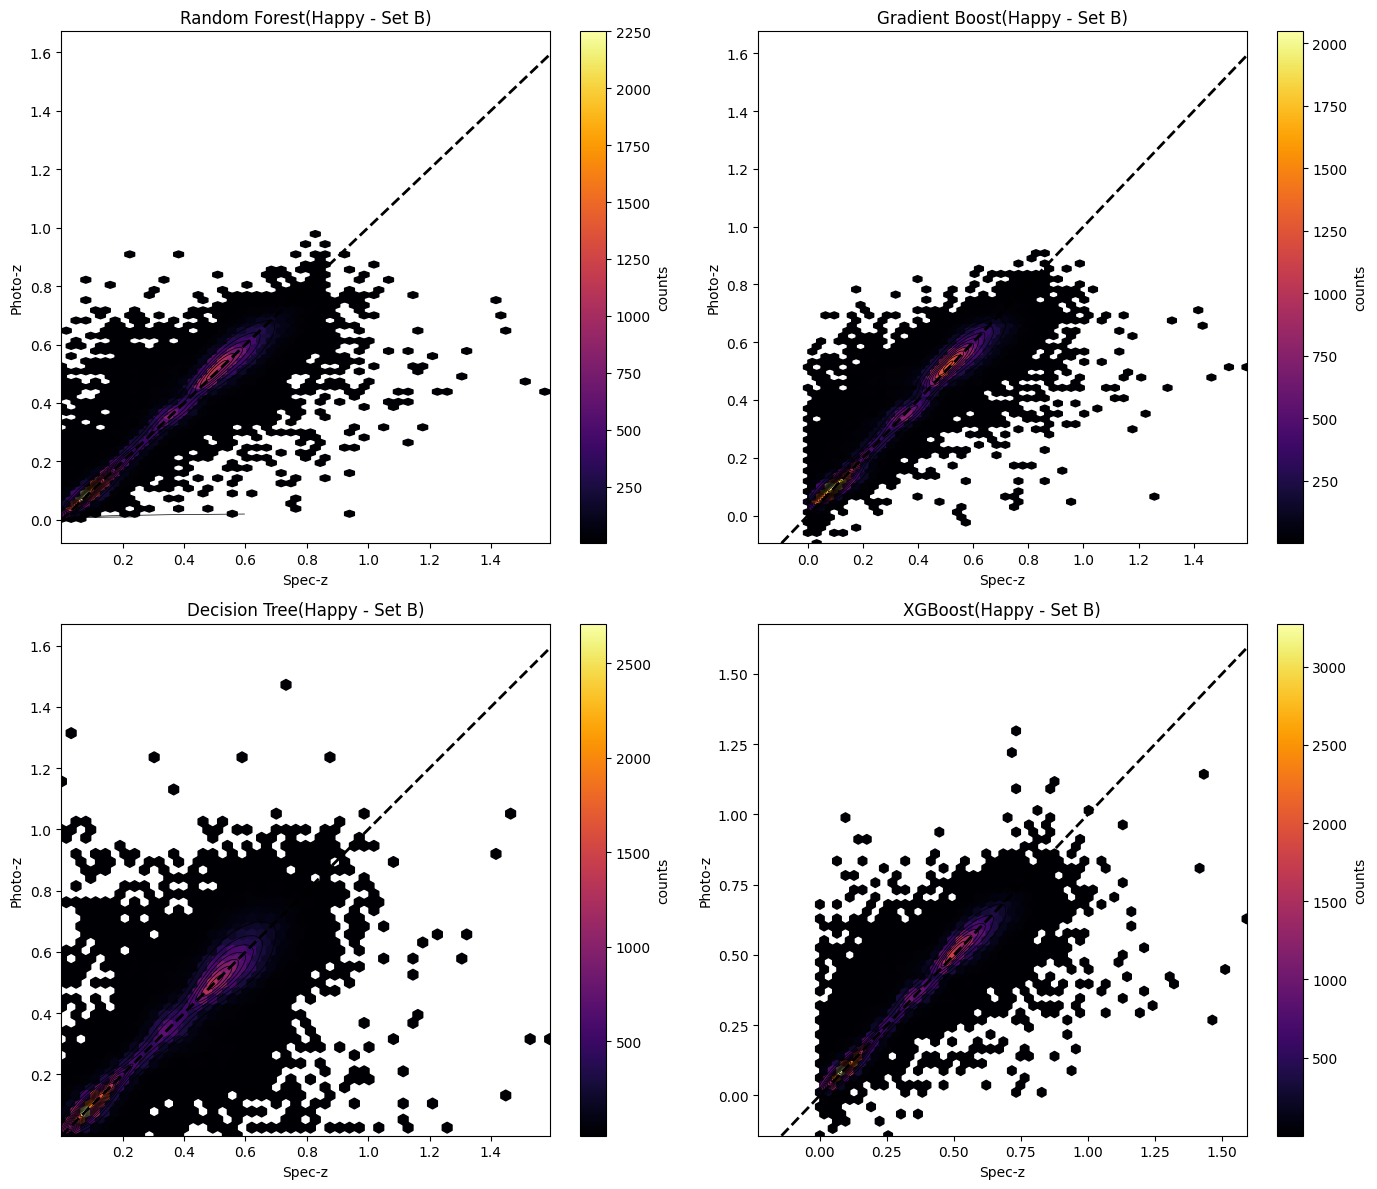

In [43]:
# Predictions and labels for Happy dataset sets B, C, D
predictions_happy_b = [y_pred_rf_happy_b, y_pred_gb_happy_b, y_pred_dt_happy_b, y_pred_xgb_happy_b]
labels_happy_b = ['Random Forest(Happy - Set B)', 'Gradient Boost(Happy - Set B)', 'Decision Tree(Happy - Set B)', 'XGBoost(Happy - Set B)']
visualize_results(y_test_happy_b, predictions_happy_b, labels_happy_b)

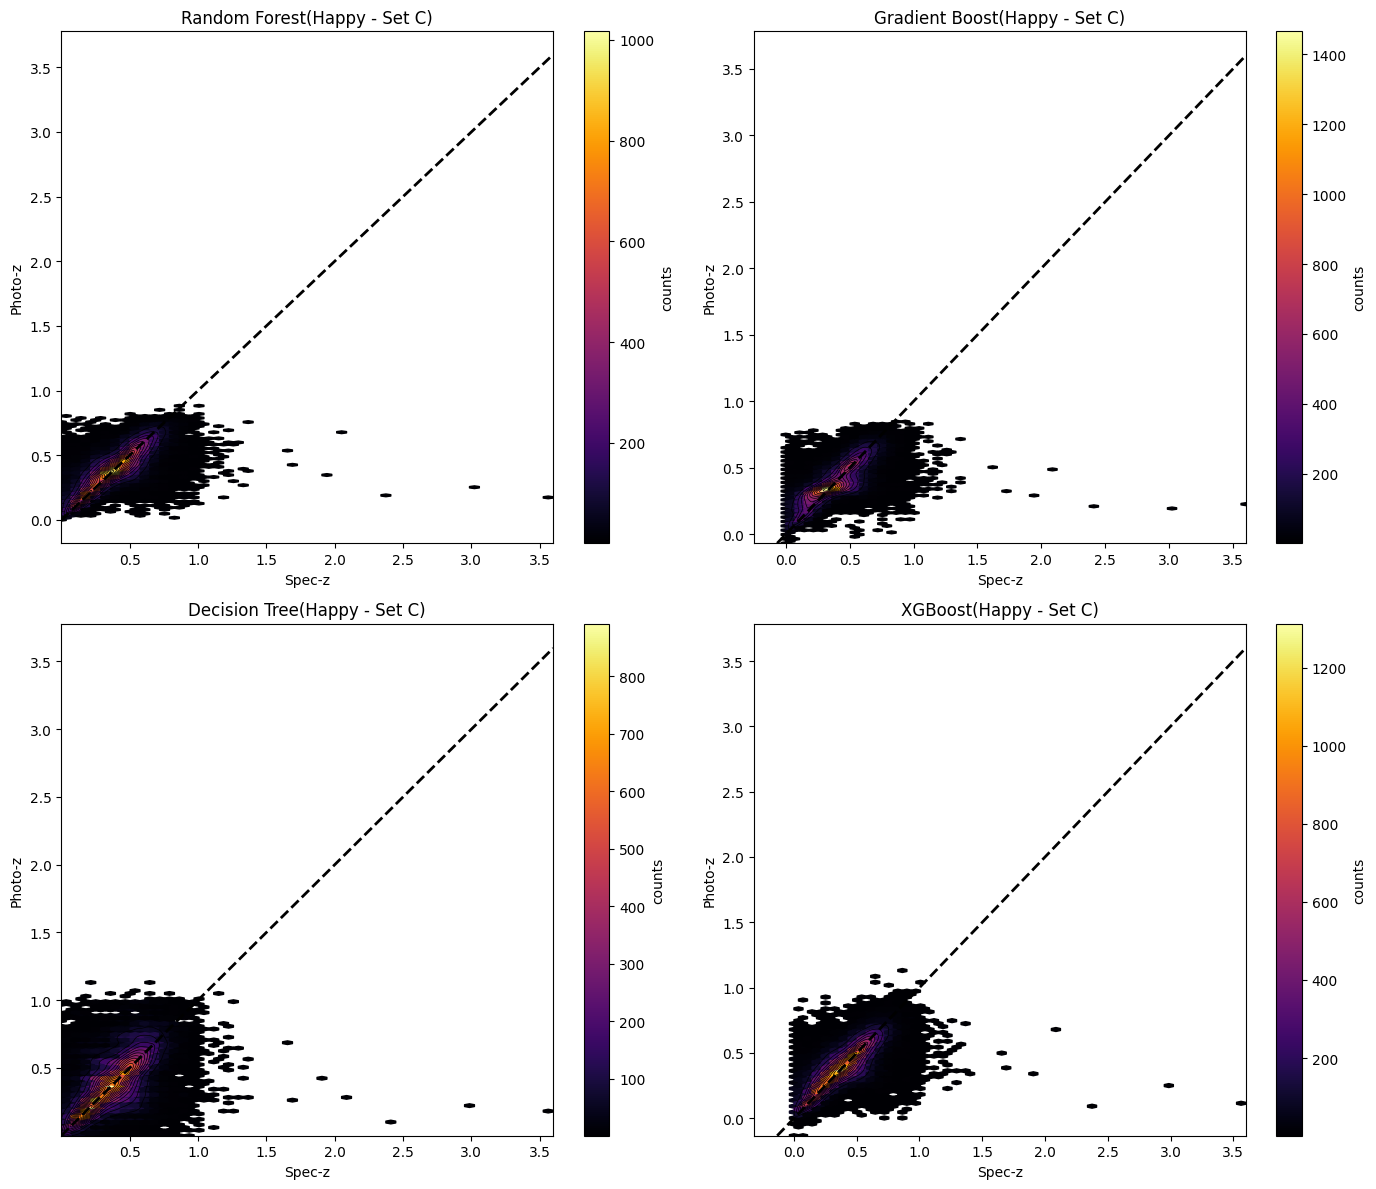

In [44]:
# Predictions and labels for Happy dataset - Set C
predictions_happy_c = [y_pred_rf_happy_c, y_pred_gb_happy_c, y_pred_dt_happy_c, y_pred_xgb_happy_c]
labels_happy_c = ['Random Forest(Happy - Set C)', 'Gradient Boost(Happy - Set C)', 'Decision Tree(Happy - Set C)', 'XGBoost(Happy - Set C)']
visualize_results(y_test_happy_c, predictions_happy_c, labels_happy_c)

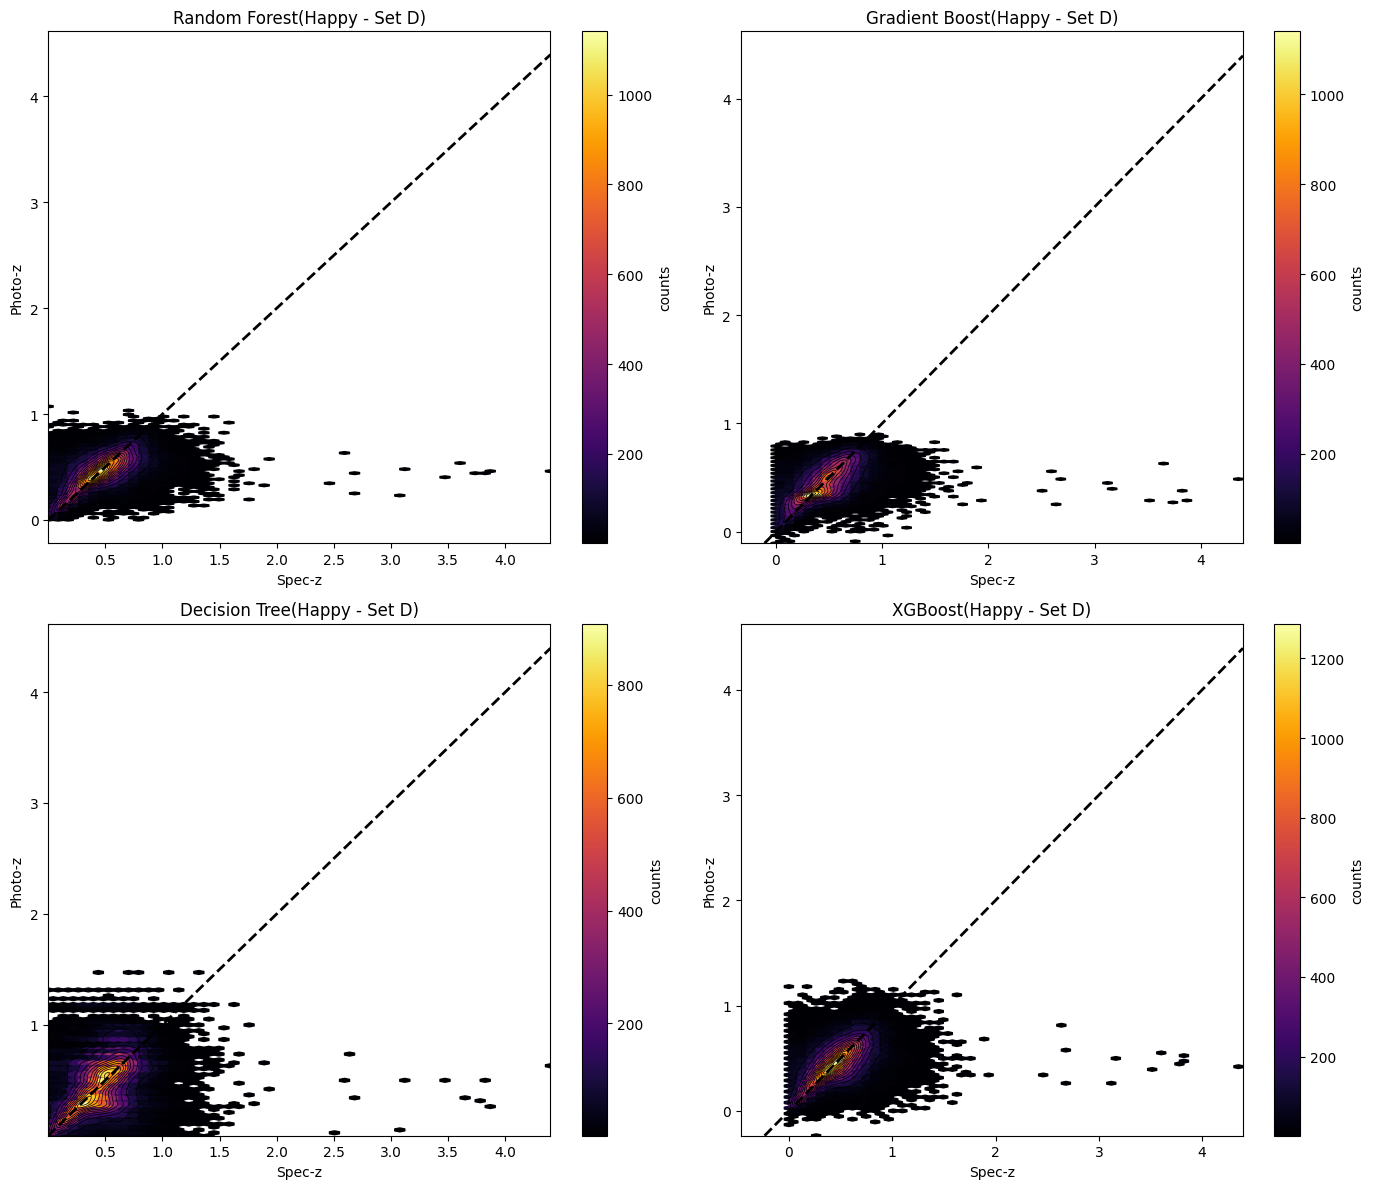

In [45]:
# Predictions and labels for Happy dataset - Set D
predictions_happy_d = [y_pred_rf_happy_d, y_pred_gb_happy_d, y_pred_dt_happy_d, y_pred_xgb_happy_d]
labels_happy_d = ['Random Forest(Happy - Set D)', 'Gradient Boost(Happy - Set D)', 'Decision Tree(Happy - Set D)', 'XGBoost(Happy - Set D)']
visualize_results(y_test_happy_d, predictions_happy_d, labels_happy_d)

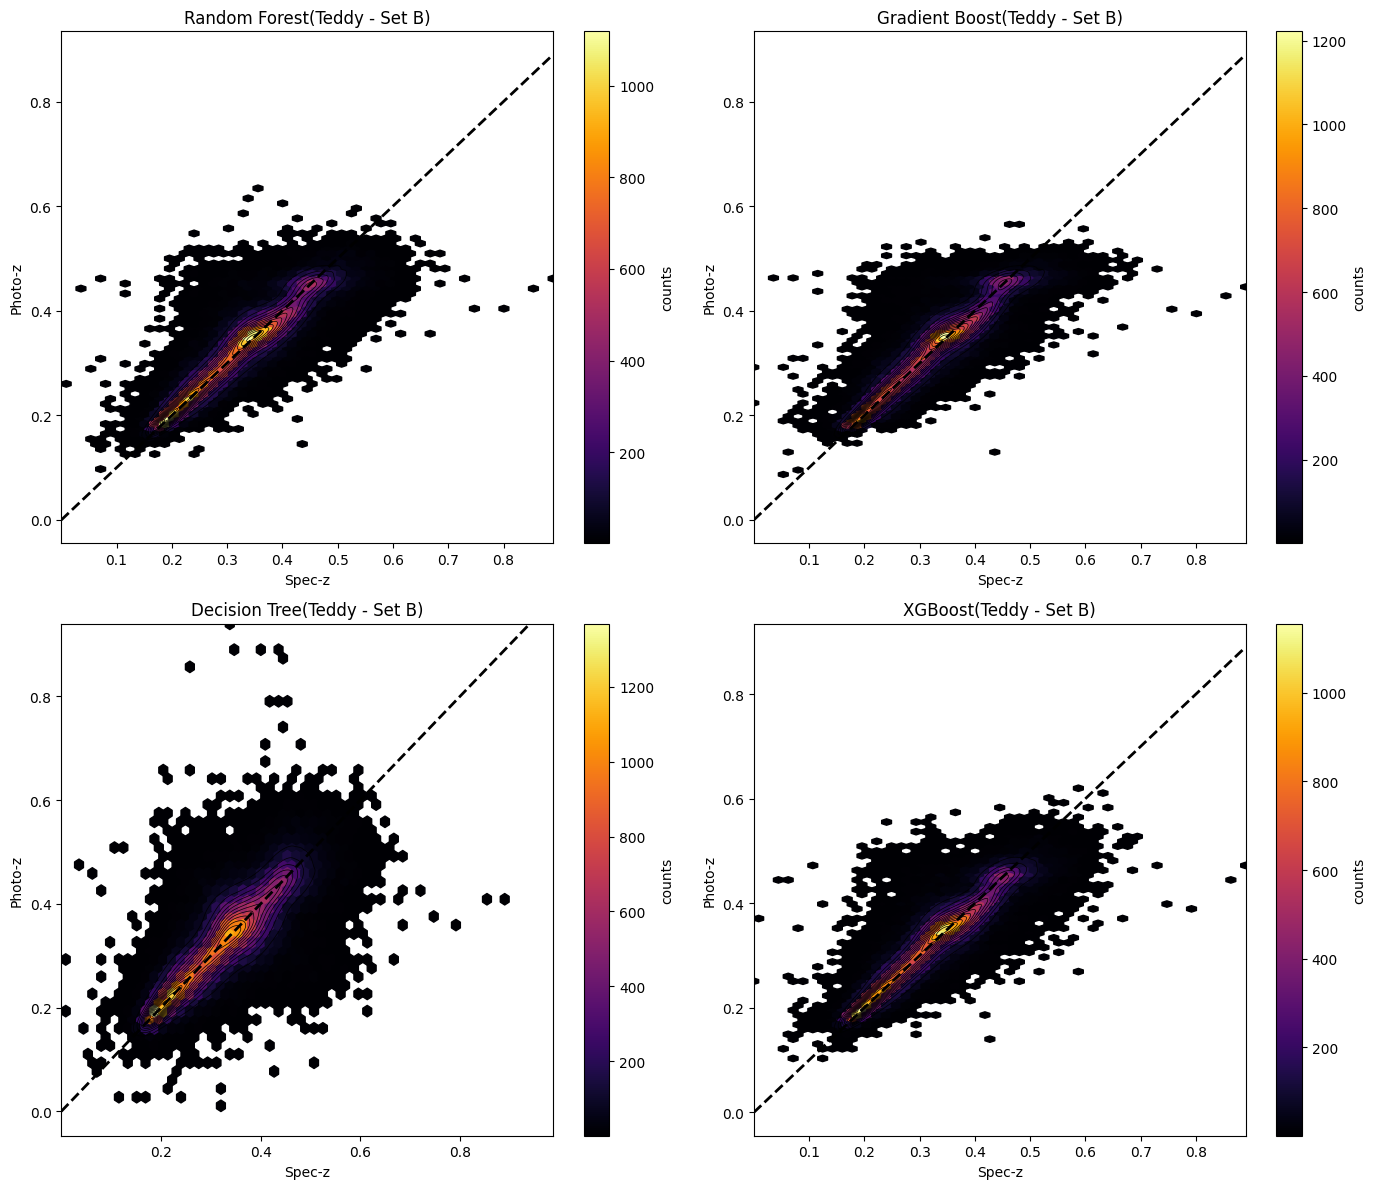

In [46]:
# Predictions and labels for Teddy dataset - Set B
predictions_teddy_b = [y_pred_rf_teddy_b, y_pred_gb_teddy_b, y_pred_dt_teddy_b, y_pred_xgb_teddy_b]
labels_teddy_b = ['Random Forest(Teddy - Set B)', 'Gradient Boost(Teddy - Set B)', 'Decision Tree(Teddy - Set B)', 'XGBoost(Teddy - Set B)']
visualize_results(y_test_teddy_b, predictions_teddy_b, labels_teddy_b)

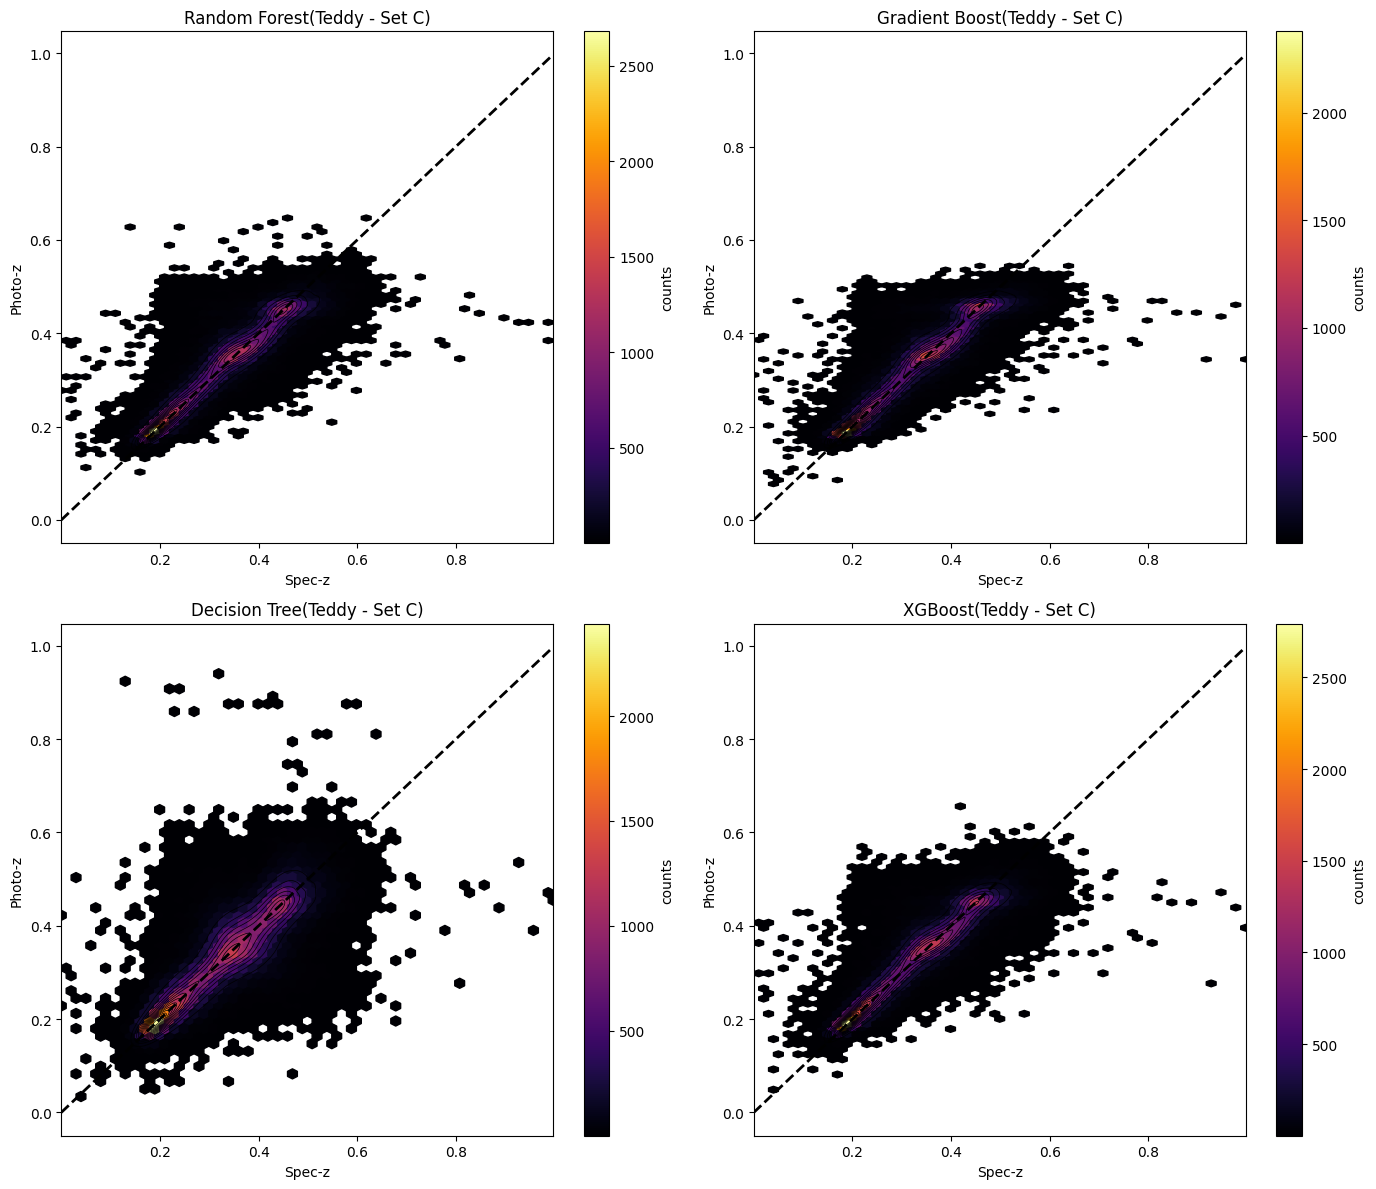

In [47]:
# Predictions and labels for Teddy dataset - Set C
predictions_teddy_c = [y_pred_rf_teddy_c, y_pred_gb_teddy_c, y_pred_dt_teddy_c, y_pred_xgb_teddy_c]
labels_teddy_c = ['Random Forest(Teddy - Set C)', 'Gradient Boost(Teddy - Set C)', 'Decision Tree(Teddy - Set C)', 'XGBoost(Teddy - Set C)']
visualize_results(y_test_teddy_c, predictions_teddy_c, labels_teddy_c)

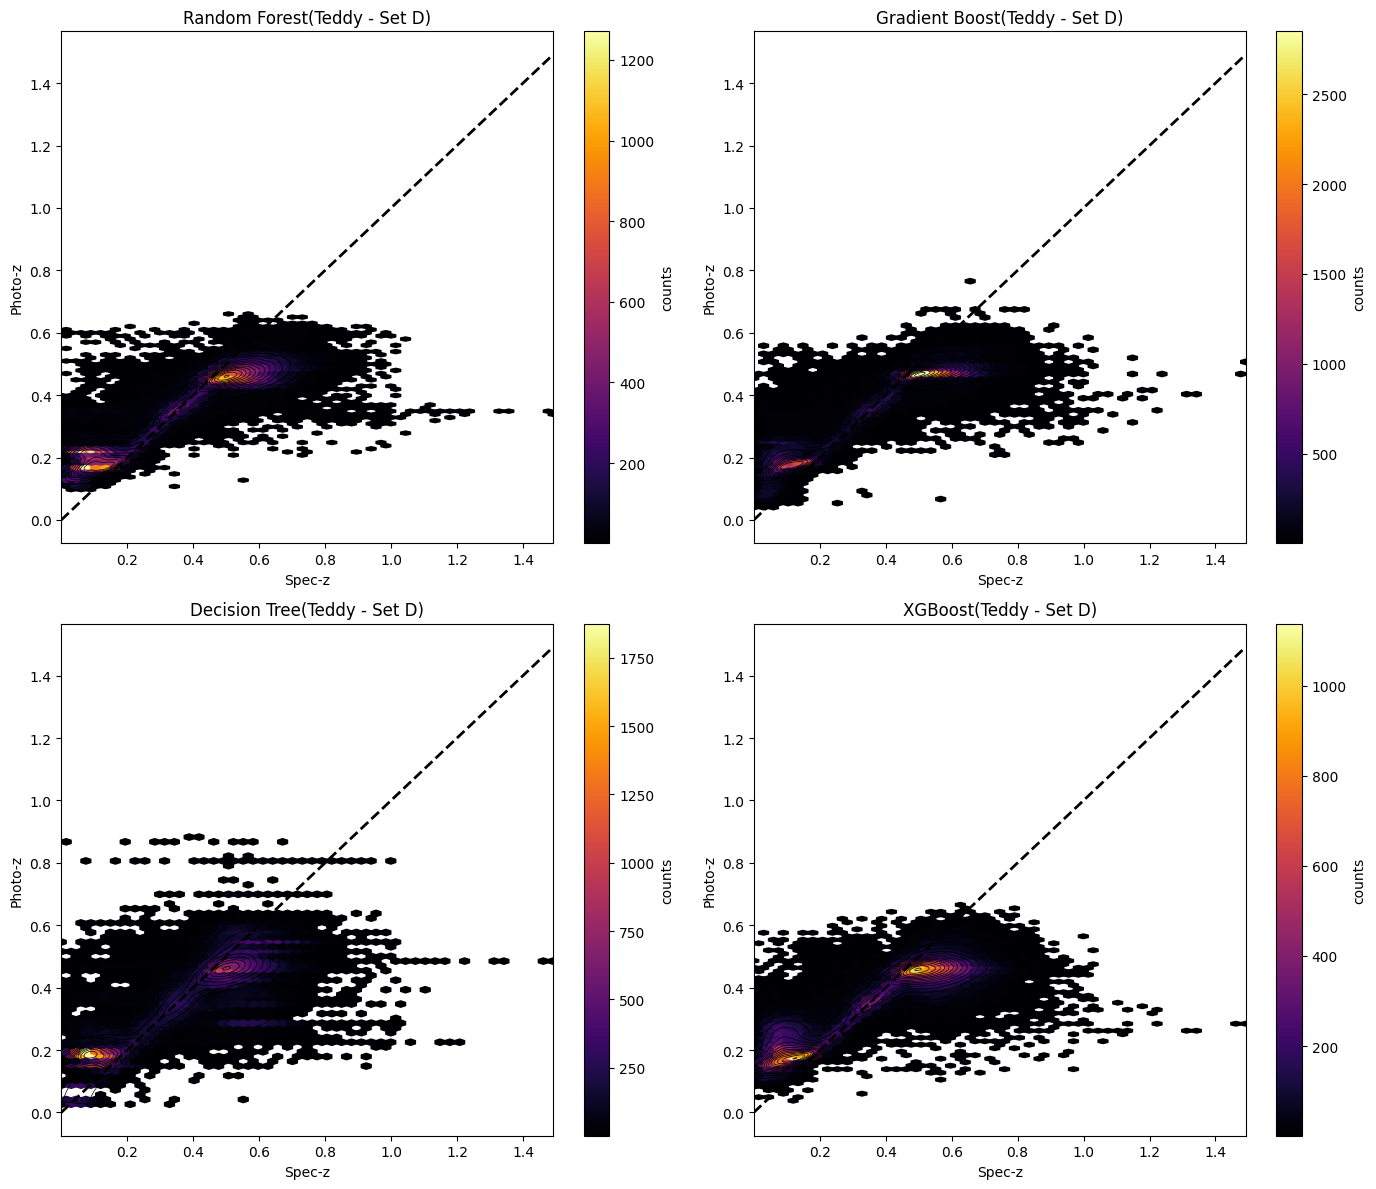

In [48]:
# Predictions and labels for Teddy dataset - Set D
predictions_teddy_d = [y_pred_rf_teddy_d, y_pred_gb_teddy_d, y_pred_dt_teddy_d, y_pred_xgb_teddy_d]
labels_teddy_d = ['Random Forest(Teddy - Set D)', 'Gradient Boost(Teddy - Set D)', 'Decision Tree(Teddy - Set D)', 'XGBoost(Teddy - Set D)']
visualize_results(y_test_teddy_d, predictions_teddy_d, labels_teddy_d)